<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_Structure_Relaxation_Phonons_Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
%%time

!conda install alignn dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda phonopy -c pytorch -c nvidia --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - alignn
    - dgl=2.1.0
    - phonopy
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    absl-py-2.1.0              |     pyhd8ed1ab_0         105 KB  conda-forge
    alignn-2024.5.27           |     pyhd8ed1ab_0          72 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_0          18 KB  conda-forge
    ase-3.23.0                 |     pyhd8ed1ab_0         1.8 MB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB  conda-forge
    babel-2.14.0               |     pyhd8ed1ab_0         7.3 MB  conda-forge
    blinke

In [2]:
from jarvis.io.vasp.inputs import Poscar
from alignn.ff.ff import (
    phonons,
    ForceField,
    AlignnAtomwiseCalculator,
    default_path,
)
from jarvis.db.figshare import get_jid_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jarvis.core.atoms import Atoms, get_supercell_dims
from tqdm import tqdm
from ase.constraints import ExpCellFilter
from sklearn.metrics import mean_absolute_error
import time
from jarvis.core.atoms import ase_to_atoms
from ase.optimize.fire import FIRE
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution



DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
jids = [
    "JVASP-1002", # Si
    "JVASP-816", # Al
    "JVASP-867", # Cu
    "JVASP-1029", # Ti
    "JVASP-861", # Cr
    "JVASP-30", # GaN Pg3mmc
    "JVASP-8169", #GaN F-43m
    "JVASP-890", #Ge
    "JVASP-8158", #SiC F-43m
    "JVASP-8118", #SiC P6_3mmc
    "JVASP-107", #SiC P6_3mc
    "JVASP-39", #AlN P6_3mc
    "JVASP-7844", #AlN F-43m
    "JVASP-35106", #Al3GaN4 P-43m
    "JVASP-1174", #GaAs F-43m
    "JVASP-1372", #AlAs F-43m
    "JVASP-91", #C Fd-3m
    "JVASP-1186", #InAs F-43M
    "JVASP-1408", #AlSb F-43M
    "JVASP-105410", #SiGe F-43m
    "JVASP-1177", #GaSb F-43m
    "JVASP-79204", #BN P63mc
    "JVASP-1393", #GaP F-43m
    "JVASP-1312", #BP F-43m
    "JVASP-1327", #AlP F-43m
    "JVASP-1183", #InP F-43m
    "JVASP-1192", #CdSe F-43m
    "JVASP-8003", #CdS F-43m
    "JVASP-96", #ZnSe F-43m
    "JVASP-1198", #ZnTe F-43m
    "JVASP-1195", #ZnO P63mc
    "JVASP-9147", #HfO2 P21c
    "JVASP-41", #SiO2 P3_221
    "JVASP-34674", #SiO2 C222_1
    "JVASP-113", #ZrO2 P2_1c
    "JVASP-32", #Al2O3 R-3c
]


In [3]:
def general_relaxer(atoms="", calculator="", fmax=0.05, steps=150):
    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms)

    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax, steps=steps)
    return ase_to_atoms(ase_atoms.atoms)


dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v5.27.2024


  0%|          | 0/1 [00:00<?, ?it/s]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si



<ipython-input-3-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 16:28:00       -7.920191        0.356293
FIRE:    1 16:28:02       -7.944047        0.312202
FIRE:    2 16:28:03       -7.980646        0.232864
FIRE:    3 16:28:05       -8.014786        0.144871
FIRE:    4 16:28:05       -8.037723        0.073753
FIRE:    5 16:28:06       -8.048141        0.017749
6.950315952301025 System
1.0
3.2264779116166893 1.563188549248559e-08 1.8628075477704324
1.0754923334268667 3.0419525619416774 1.8628075432122972
3.201190687691414e-07 2.2077579664909995e-07 3.7256155045228967
Si 
2 
direct
0.8749991645886974 0.8750002208896706 0.8749975676979155 Si
0.12499999971726508 0.12500015881119428 0.12499963048426119 Si




100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


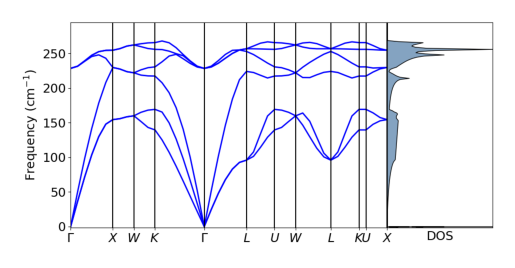

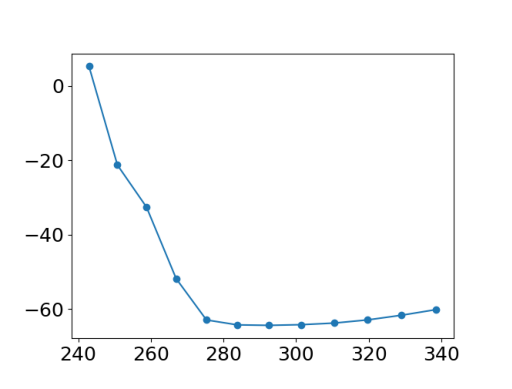

100%|██████████| 1/1 [00:52<00:00, 52.17s/it]


In [9]:
jids=['JVASP-1002']
model_filename='best_model.pt'
model_path = default_path()
aff_lat = []
wiki_lat = []
formulas = []
for jid in tqdm(jids, total=len(jids)):
    s = Atoms.from_dict(get_jid_data(jid=jid, dataset="dft_3d")["atoms"])
    calc = AlignnAtomwiseCalculator(
        path=model_path,
        force_mult_natoms=False,
        force_multiplier=1,
        stress_wt=0.3,
        modl_filename=model_filename,
        # stress_wt=-4800,
    )
    print(s)
    t1 = time.time()
    formula=s.composition.reduced_formula
    opt = general_relaxer(atoms=s, calculator=calc)
    t2 = time.time()
    aff_lat.append(opt.lattice_mat[0][0])
    formulas.append(s.composition.reduced_formula)
    print(t2 - t1, opt)  # , w cs, mean_absolute_error(iki_lat, aff_lat))
    strains = np.arange(-0.06, 0.06, 0.01)
    vols = []
    ens = []
    for i in tqdm(strains):
        calc = AlignnAtomwiseCalculator(
            path=model_path,
            force_mult_natoms=False,
            force_multiplier=1,
            stress_wt=0.3,
            model_filename=model_filename,
            # stress_wt=-4800,
        )
        sup = opt.make_supercell_matrix([2, 2, 2])
        atms = sup.strain_atoms(i)
        # atms=opt.strain_atoms(i)
        ase_atoms = atms.ase_converter()
        ase_atoms.calc = calc
        en = ase_atoms.get_potential_energy()
        ens.append(en)
        vols.append(atms.volume)
        # vols.append(atms.volume**(1/3))
    plt.plot(vols, ens, "-o")
    fname = "ev_" + jid +"_"+formula+ ".png"
    plt.savefig(fname)
    plt.close()
    atoms = opt.get_primitive_atoms
    # Atoms.from_dict(get_jid_data(jid='JVASP-816',dataset='dft_3d')['atoms'])

    phonopy_bands_figname = "ph_" + jid +"_"+formula+ ".png"
    ph = phonons(
        model_path=model_path,
        atoms=atoms,
        phonopy_bands_figname=phonopy_bands_figname,
        force_mult_natoms=True,
    )
    plt.figure()
    plt.axis('off')
    plt.imshow(plt.imread(phonopy_bands_figname))
    plt.show()
    plt.close()

    plt.figure()
    plt.axis('off')
    plt.imshow(plt.imread(fname))
    plt.show()
    plt.close()

In [6]:
!ls -altr

total 132
drwxr-xr-x 4 root root  4096 Jun 27 13:25 .config
drwxr-xr-x 1 root root  4096 Jun 27 13:26 sample_data
drwxr-xr-x 1 root root  4096 Jun 30 16:04 ..
-rw-r--r-- 1 root root 22537 Jun 30 16:05 condacolab_install.log
-rw-r--r-- 1 root root 17045 Jun 30 16:13 ev_JVASP-1002_Si.png
drwxr-xr-x 1 root root  4096 Jun 30 16:14 .
-rw-r--r-- 1 root root 70756 Jun 30 16:14 ph_JVASP-1002_Si.png
